In [45]:
import numpy as np
import math as math
import copy
import matplotlib.pyplot as plt
from sklearn import preprocessing 
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import csv
import cv2
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.integrate import quad
import sklearn
import codecs, json 
import scipy.io
import h5py
import pandas as pd

device=torch.device("cuda:0")

# Import topnet utilities
import sys
sys.path.insert(0, '/home/ephy/Projects/tda_convolution/src/')
import topnet
import importlib
importlib.reload(topnet)

<module 'topnet' from '/home/ephy/Projects/tda_convolution/src/topnet.py'>

In [46]:
datadir='/home/ephy/Projects/tda_convolution/data/original/SVHN/'
trainmat = scipy.io.loadmat(datadir+'train_32x32.mat')
testmat = scipy.io.loadmat(datadir+'test_32x32.mat')

In [47]:
# Resize to MNIST and change to grayscale
X=list()
for i in range(trainmat['X'].shape[3]):
    X.append(cv2.resize(trainmat['X'][...,i], (28,28)))
    
for i in range(testmat['X'].shape[3]):
    X.append(cv2.resize(testmat['X'][...,i], (28,28)))
    
# X=torch.tensor(np.dot(X[...,:3], [0.299, 0.587, 0.114]), dtype=torch.float32).view(-1,1,32,32)
X=np.dot((np.array(X)/255)[...,:3], [0.299, 0.587, 0.114])

In [48]:
train_y = np.array(trainmat['y']).flatten()
test_y = np.array(testmat['y']).flatten()
y=np.append(train_y,test_y)
classes=len(np.unique(y))
y[y==10]=0 # swtich coding of classes

### Classes are not ballanced in SVHN, so let's just make even samples

In [49]:
y_ballanced=list()
X_ballanced=list()

n = np.arange(np.min(np.histogram(np.array(y))[0]))
np.random.shuffle(n)
for i in range(classes):
    y_ballanced.append(y[y==(i)][n])
    X_ballanced.append(X[y==(i)][n])
    
X_ballanced = np.array(X_ballanced)
X_ballanced = X_ballanced.reshape(np.product(X_ballanced.shape[0:2]),X_ballanced.shape[2],X_ballanced.shape[3])
y_ballanced = np.array(y_ballanced)
y_ballanced = y_ballanced.reshape(np.product(y_ballanced.shape[0:2]))

In [50]:
train_X , test_X , train_y , test_y = train_test_split(X_ballanced , y_ballanced, 
                                                test_size = 0.2 ,
                                                random_state = 1)

In [51]:
classes=list(range(10))
train_X = torch.tensor(train_X,  dtype=torch.float32)
test_X = torch.tensor(test_X,  dtype=torch.float32)
train_y = torch.tensor(np.array([[int(n) for n in x==classes] for x in train_y]), dtype=torch.float32)
test_y = torch.tensor(np.array([[int(n) for n in x==classes] for x in test_y]), dtype=torch.float32)

## Load MNIST

In [52]:
REBUILD_DATA = False
datadir = '/home/ephy/Projects/tda_init_cnn/data/'

train = datasets.MNIST(datadir+"original/", train=True, download=False, 
                      transform= transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST(datadir+"original/", train=True, download=False, 
                      transform= transforms.Compose([transforms.ToTensor()]))

In [53]:
mnist_train_X = torch.tensor([np.array(i[0]) for i in train])
mnist_test_X = torch.tensor([np.array(i[0]) for i in test])
mnist_train_y = [i[1] for i in train]
mnist_test_y = [i[1] for i in test]

In [54]:
classes=np.unique(mnist_train_y)
mnist_test_y = torch.tensor([np.array([int(n) for n in x==classes]) for x in mnist_test_y], dtype=torch.float32)
mnist_train_y = torch.tensor([np.array([int(n) for n in x==classes]) for x in mnist_train_y], dtype=torch.float32)

In [55]:
configs=dict()
config = dict()
config['weights_config']=[[('Klein',8,8,3,None)],None]
config['freeze_layers']=[True,False]
config['membership_config']=[None,[('Klein',8,8,3,.35)]]
config['convLayerSpecs']=[(1,64,3),(64,64,3)]
config['pools']=[None,None]
config['activations']=[None, 'F.relu']
config['learning_rate']=1e-5
config['classes']=len(classes)
config['imageDim']=(28,28)
config['test_X']=test_X
config['test_y']=test_y
config['train_y']=train_y
config['train_X']=train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=1
config['dataset']='SVHN'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['KF + KOL'] = config

config = dict()
config['weights_config']=[[('Circle',3,64,None)],None]
config['freeze_layers']=[True,False]
config['membership_config']=[None,[('Circle',3,64,.65)]]
config['convLayerSpecs']=[(1,64,3),(64,64,3)]
config['pools']=[None,None]
config['activations']=[None, 'F.relu']
config['learning_rate']=1e-5
config['classes']=len(classes)
config['imageDim']=(28,28)
config['test_X']=test_X
config['test_y']=test_y
config['train_y']=train_y
config['train_X']=train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=1
config['dataset']='SVHN'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['CF + COL'] = config

config = dict()
config['weights_config']=[[('Klein',8,8,3,None)],None]
config['freeze_layers']=[True,False]
config['membership_config']=[None,[('Circle',3,64,.65)]]
config['convLayerSpecs']=[(1,64,3),(64,64,3)]
config['pools']=[None,None]
config['activations']=[None, 'F.relu']
config['learning_rate']=1e-5
config['classes']=len(classes)
config['imageDim']=(28,28)
config['test_X']=test_X
config['test_y']=test_y
config['train_y']=train_y
config['train_X']=train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=1
config['dataset']='SVHN'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['KF + COL'] = config

config = dict()
config['weights_config']=[[('Circle',3,64,None)],None]
config['freeze_layers']=[True,False]
config['membership_config']=[None,[('Klein',8,8,3,.35)]]
config['convLayerSpecs']=[(1,64,3),(64,64,3)]
config['pools']=[None,None]
config['activations']=[None, 'F.relu']
config['learning_rate']=1e-5
config['classes']=len(classes)
config['imageDim']=(28,28)
config['test_X']=test_X
config['test_y']=test_y
config['train_y']=train_y
config['train_X']=train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=1
config['dataset']='SVHN'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['CF + KOL'] = config

config = dict()
config['weights_config']=[None,None]
config['freeze_layers']=[False,False]
config['membership_config']=[None,None]
config['convLayerSpecs']=[(1,64,3),(64,64,3)]
config['pools']=[None,None]
config['activations']=['F.relu', 'F.relu']
config['learning_rate']=1e-5
config['classes']=len(classes)
config['imageDim']=(28,28)
config['test_X']=test_X
config['test_y']=test_y
config['train_y']=train_y
config['train_X']=train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=1
config['dataset']='SVHN'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['NOL + NOL'] = config

In [14]:
# results=dict()
# torch.cuda.empty_cache()
# results['SVHN'] = topnet.run_configs(configs, None)
results['SVHN'] = topnet.run_configs(configs, None)


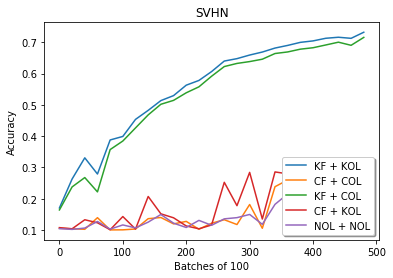

In [16]:
dataset='SVHN'
configuration=results[dataset]
for name, item in configuration.items():
    plt.plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],item['accuracies'], label=name)    
plt.ylabel('Accuracy')
plt.xlabel('Batches of '+ str(next(iter(configuration.items()))[1]['config']['batchSize']))
plt.title(dataset)
legend = plt.legend(loc='lower right', shadow=True)
plt.show()

In [16]:
mnist_configs = copy.deepcopy(configs)
for key, config in mnist_configs.items():
    config['classes']=len(classes)
    config['test_X']=mnist_test_X
    config['test_y']=mnist_test_y
    config['train_y']=mnist_train_y
    config['train_X']=mnist_train_X
    config['batchesPerTest']=20
    config['dataset']='MNIST'

In [17]:
results['MNIST'] = topnet.run_configs(mnist_configs, None)

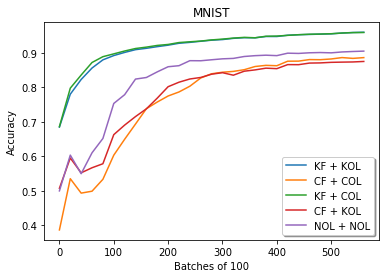

In [19]:
dataset='MNIST'
configuration=results[dataset]
for name, item in configuration.items():
    plt.plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],item['accuracies'], label=name)    
plt.ylabel('Accuracy')
plt.xlabel('Batches of '+ str(next(iter(configuration.items()))[1]['config']['batchSize']))
plt.title(dataset)
legend = plt.legend(loc='lower right', shadow=True)
plt.show()

## Load USPS Digits

In [56]:
classes=list(range(10))
with h5py.File('/home/ephy/Projects/tda_convolution/data/original/USPS/usps.h5', 'r') as hf:
        usps_train_X = hf.get('train').get('data')[:]
        usps_train_y = hf.get('train').get('target')[:]
        usps_test_X = hf.get('test').get('data')[:]
        usps_test_y = hf.get('test').get('target')[:]
        
usps_train_X = torch.tensor(usps_train_X.reshape(-1,16,16), dtype=torch.float32)
usps_test_X = torch.tensor(usps_test_X.reshape(-1,16,16), dtype=torch.float32)
usps_train_y = torch.tensor(np.array([[int(n) for n in x==classes] for x in usps_train_y]), dtype=torch.float32)
usps_test_y = torch.tensor(np.array([[int(n) for n in x==classes] for x in usps_test_y]), dtype=torch.float32)


In [61]:
usps_configs = copy.deepcopy(configs)
for key, config in usps_configs.items():
    config['classes']=len(classes)
    config['imageDim']=(16,16)
    config['test_X']=usps_test_X
    config['test_y']=usps_test_y
    config['train_y']=usps_train_y
    config['train_X']=usps_train_X
    config['batchesPerTest']=5
    config['dataset']='USPS'
    config['learning_rate']=1e-4

In [62]:
results['USPS'] = topnet.run_configs(usps_configs, None)

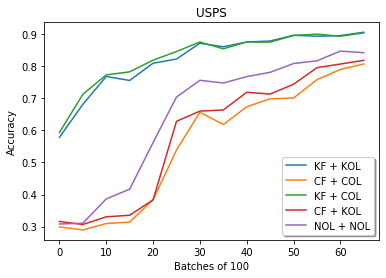

In [63]:
dataset='USPS'
configuration=results[dataset]
for name, item in configuration.items():
    plt.plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],item['accuracies'], label=name)    
plt.ylabel('Accuracy')
plt.xlabel('Batches of '+ str(next(iter(configuration.items()))[1]['config']['batchSize']))
plt.title(dataset)
legend = plt.legend(loc='lower right', shadow=True)
plt.show()

Save these results

In [5]:
# np.save('/home/ephy/Projects/tda_convolution/data/digits_training_size_newPoly', results)
results = np.load('/home/ephy/Projects/tda_convolution/data/digits_training_size_newPoly.npy', allow_pickle=True)
results = results.item()

In [16]:
# # np.save('/home/ephy/Projects/tda_convolution/data/digits_training_size', results)
# results = np.load('/home/ephy/Projects/tda_convolution/data/digits_training_size.npy', allow_pickle=True)
# results = results.item()

## Graph first to several accuracies on MNIST

In [6]:
datasets = ['MNIST', 'SVHN', 'USPS']
accdat = dict()
for dataset in datasets:
    configuration=results[dataset]
    acc_2000=[]
    for name, item in configuration.items():
        acc_2000.append(item['accuracies'][int(2000/(item['config']['batchesPerTest']*item['config']['batchSize']) - 1)])
    accdat[dataset]=acc_2000
dataset=datasets[2]
configuration=results[dataset]
acc_2000_2=[]
names=[]
for name, item in configuration.items():
    names.append(name)

In [7]:
df = pd.DataFrame(data=accdat)
df = df.transpose()
df.columns =names

In [8]:
df = df[['KF + KOL', 'KF + COL', 'NOL + NOL', 'CF + COL', 'CF + KOL']]

In [9]:
colordict={'KF + COL': '#de6eeb','NOL + NOL': '#1f77b4', 'KF + KOL': '#ff7f0e',
           'KF + NOL': '#2ca02c', 'CF + COL': '#d62728', 'CF + NOL': '#9467bd',
          'CF + KOL': '#b4de49', 'Gabor + NOL': '#03fc90'}

/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


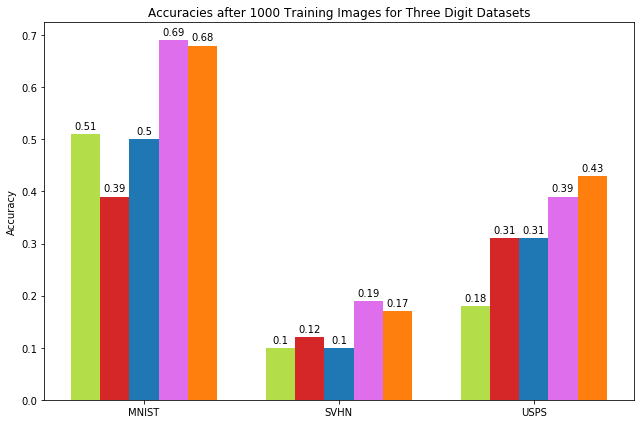

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 6)
rects=[]
positions = np.arange(3)
width = 0.15
for i, column in enumerate(df.columns.tolist()):
    rects.append(ax.bar(positions-((width)*i), np.round(np.array(df[column]),2), width=width, label=column,
                        color=colordict[column]))

ax.set_ylabel('Accuracy')
ax.set_title('Accuracies after 1000 Training Images for Three Digit Datasets')
# ax.legend(loc='center right', bbox_to_anchor=(1.2,.5))
fig.tight_layout()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

for rect in rects:
    autolabel(rect)
ax.set_xticks(positions-width*2)
ax.set_xticklabels(df.index.tolist())
fig.show()

In [29]:
fig.savefig('/home/ephy/Projects/tda_convolution/fig/accuraciesAt1000_Newpoly.png', dpi=300, bbox_inches='tight')

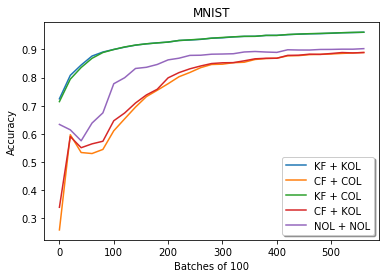

In [28]:
dataset=datasets[0]
configuration=results[dataset]
for name, item in configuration.items():
    plt.plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],item['accuracies'], label=name)    
plt.ylabel('Accuracy')
plt.xlabel('Batches of '+ str(next(iter(configuration.items()))[1]['config']['batchSize']))
plt.title(dataset)
legend = plt.legend(loc='lower right', shadow=True)
plt.show()

## Adding sparsity

In [67]:
def sample_data(n):
    n = np.arange(n)
    np.random.shuffle(n)
    return n

In [247]:
s=sample_data(30000)
for key, config in configs.items():
    config['imageDim']=(28,28)
    config['classes']=len(classes)
    config['test_X']=mnist_test_X
    config['test_y']=mnist_test_y
    config['train_y']=mnist_train_y[s]
    config['train_X']=mnist_train_X[s]
    config['batchesPerTest']=20
    config['batchSize']=100
    config['dataset']='MNIST 30,000'

In [248]:
results['MNIST 30,000'] = topnet.run_configs(configs, None)

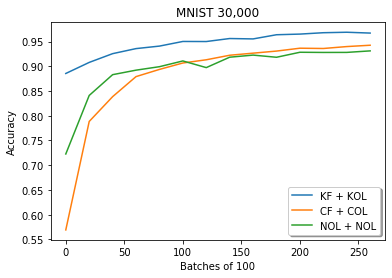

In [249]:
dataset='MNIST 30,000'
configuration=results[dataset]
for name, item in configuration.items():
    plt.plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],item['accuracies'], label=name)    
plt.ylabel('Accuracy')
plt.xlabel('Batches of '+ str(next(iter(configuration.items()))[1]['config']['batchSize']))
plt.title(dataset)
legend = plt.legend(loc='lower right', shadow=True)
plt.show()

In [250]:
s=sample_data(15000)
for key, config in configs.items():
    config['imageDim']=(28,28)
    config['classes']=len(classes)
    config['test_X']=mnist_test_X
    config['test_y']=mnist_test_y
    config['train_y']=mnist_train_y[s]
    config['train_X']=mnist_train_X[s]
    config['batchesPerTest']=20
    config['batchSize']=100
    config['dataset']='MNIST 15,000'

In [251]:
results['MNIST 15,000'] = topnet.run_configs(configs, None)

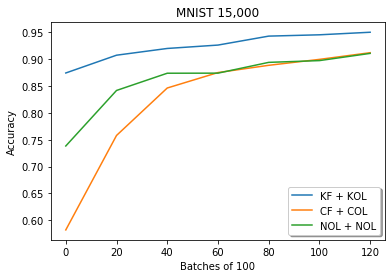

In [252]:
dataset='MNIST 15,000'
configuration=results[dataset]
for name, item in configuration.items():
    plt.plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],item['accuracies'], label=name)    
plt.ylabel('Accuracy')
plt.xlabel('Batches of '+ str(next(iter(configuration.items()))[1]['config']['batchSize']))
plt.title(dataset)
legend = plt.legend(loc='lower right', shadow=True)
plt.show()

In [282]:
s=sample_data(5000)
for key, config in configs.items():
    config['imageDim']=(28,28)
    config['classes']=len(classes)
    config['test_X']=mnist_test_X
    config['test_y']=mnist_test_y
    config['train_y']=mnist_train_y[s]
    config['train_X']=mnist_train_X[s]
    config['batchesPerTest']=10
    config['batchSize']=50
    config['dataset']='MNIST 5000'

In [283]:
results['MNIST 5,000'] = topnet.run_configs(configs, None)

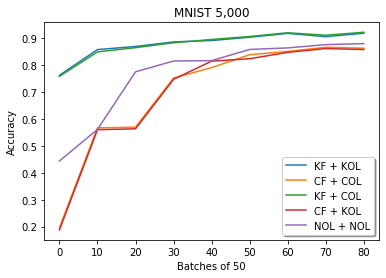

In [284]:
dataset='MNIST 5,000'
configuration=results[dataset]
for name, item in configuration.items():
    plt.plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],item['accuracies'], label=name)    
plt.ylabel('Accuracy')
plt.xlabel('Batches of '+ str(next(iter(configuration.items()))[1]['config']['batchSize']))
plt.title(dataset)
legend = plt.legend(loc='lower right', shadow=True)
plt.show()

## Plot MNIST sparsities all as one plot

In [ ]:
fig, axarr = plt.subplots(3, sharex=True,sharey=True)
fig.suptitle('Accuracy on MNIST ')
dataset='MNIST'
configuration=results[dataset]
for name, item in configuration.items():
    axarr[0].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['accuracies'], label=name)
dataset='SVHN'
configuration=results[dataset]
for name, item in configuration.items():
    axarr[1].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['accuracies'])
dataset='USPS'
configuration=results[dataset]
for name, item in configuration.items():
    axarr[2].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['accuracies'])
    
axarr[0].set(ylabel='MNIST')
axarr[1].set(ylabel='SVHN')
axarr[2].set(ylabel='USPS')
fig.legend(loc='center right', shadow=True, bbox_to_anchor=(1.15,.38))
fig.set_figheight(6)
fig.set_figwidth(6)
axarr[2].set_xlabel('Batches of 100')
fig.show()

## Plot MNIST, SVHN, USPS in ascending sparsities

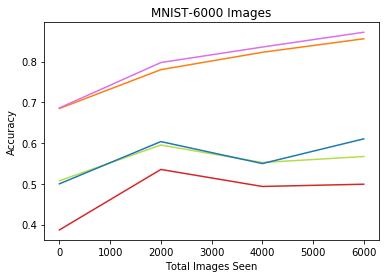

In [39]:
# fig.suptitle('Accuracy on Several Digit Datasets')
dataset='MNIST'
configuration=results[dataset]
for name, item in configuration.items():
    a=[i*item['config']['batchesPerTest']*item['config']['batchSize'] for i in range(len(item['accuracies']))]
    plt.plot([i*item['config']['batchesPerTest']*item['config']['batchSize'] for i in range(len(item['accuracies']))][0:4],
             item['accuracies'][0:4], label=name, color=colordict[name])
plt.xlabel('Total Images Seen')
plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
plt.title('MNIST-6000 Images')
plt.show()

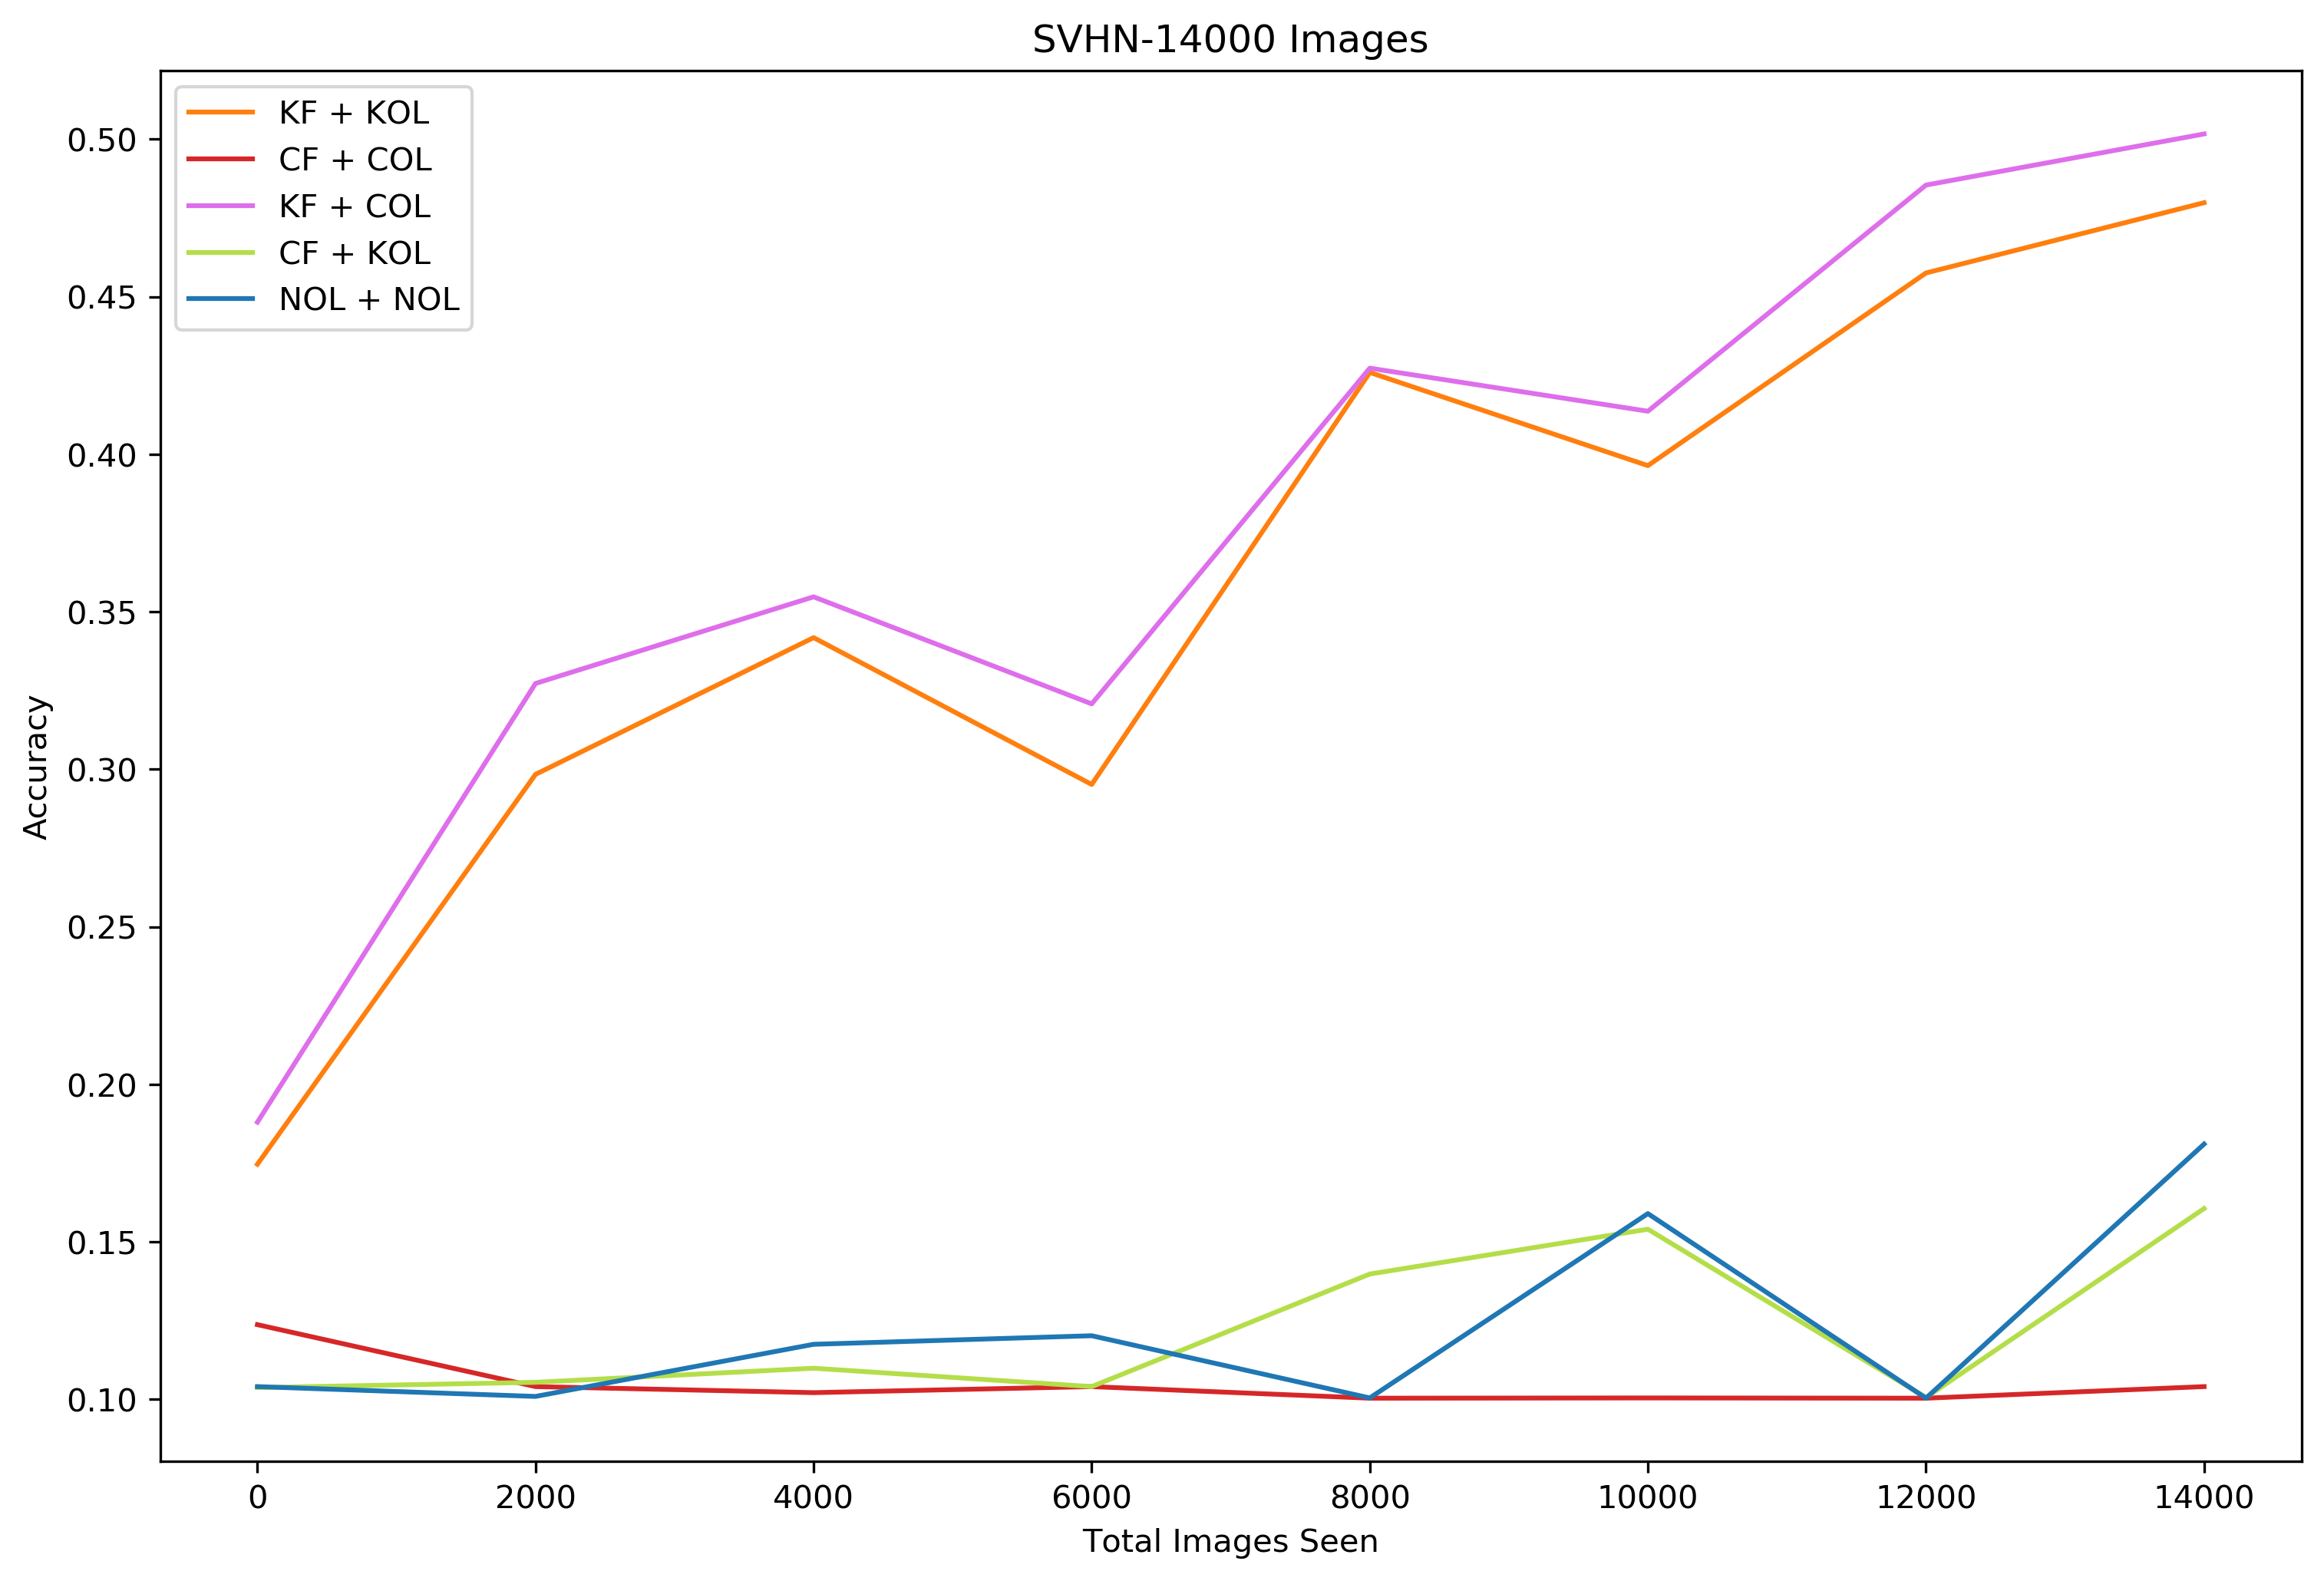

In [71]:
# fig.suptitle('Accuracy on Several Digit Datasets')
fig = plt.figure(figsize=(12,8), dpi= 300)
dataset='SVHN'
configuration=results[dataset]
for name, item in configuration.items():
    a=[i*item['config']['batchesPerTest']*item['config']['batchSize'] for i in range(len(item['accuracies']))]
    plt.plot([i*item['config']['batchesPerTest']*item['config']['batchSize'] for i in range(len(item['accuracies']))][0:8],
             item['accuracies'][0:8], label=name, color=colordict[name])
plt.xlabel('Total Images Seen')
plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
plt.title('SVHN-14000 Images')
plt.legend()
plt.show()

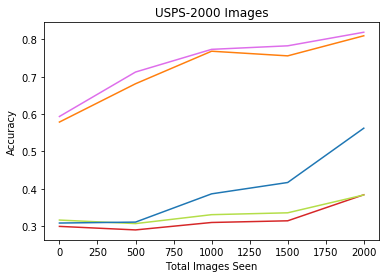

In [68]:
# fig.suptitle('Accuracy on Several Digit Datasets')
dataset='USPS'
configuration=results[dataset]
for name, item in configuration.items():
    a=[i*item['config']['batchesPerTest']*item['config']['batchSize'] for i in range(len(item['accuracies']))]
    plt.plot([i*item['config']['batchesPerTest']*item['config']['batchSize'] for i in range(len(item['accuracies']))][0:5],
             item['accuracies'][0:5], label=name, color=colordict[name])
plt.xlabel('Total Images Seen')
plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
plt.title('USPS-2000 Images')
plt.show()

/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


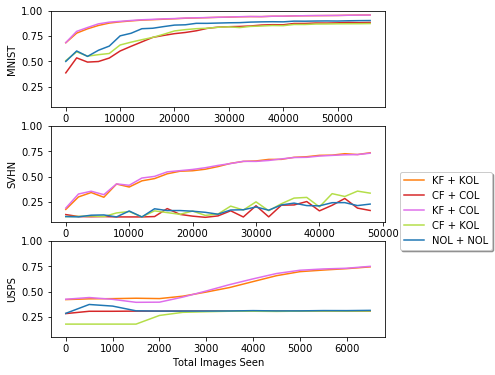

In [11]:
fig, axarr = plt.subplots(3, sharex=False,sharey=True)
# fig.suptitle('Accuracy on Several Digit Datasets')
dataset='MNIST'
configuration=results[dataset]
for name, item in configuration.items():
    axarr[0].plot([i*item['config']['batchesPerTest']*item['config']['batchSize'] for i in range(len(item['accuracies']))],
             item['accuracies'], label=name, color=colordict[name])
dataset='SVHN'
configuration=results[dataset]
for name, item in configuration.items():
    axarr[1].plot([i*item['config']['batchesPerTest']*item['config']['batchSize'] for i in range(len(item['accuracies']))],
             item['accuracies'], color=colordict[name])
dataset='USPS'
configuration=results[dataset]
for name, item in configuration.items():
    axarr[2].plot([i*item['config']['batchesPerTest']*item['config']['batchSize'] for i in range(len(item['accuracies']))],
             item['accuracies'], color=colordict[name])
    
axarr[0].set(ylabel='MNIST')
axarr[1].set(ylabel='SVHN')
axarr[2].set(ylabel='USPS')
fig.legend(loc='center right', shadow=True, bbox_to_anchor=(1.15,.38))
fig.set_figheight(6)
fig.set_figwidth(6)
axarr[2].set_xlabel('Total Images Seen')
fig.show()

In [31]:
fig.savefig('/home/ephy/Projects/tda_convolution/fig/accRateInDigits_newPoly.png', dpi=300, bbox_inches='tight')

/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


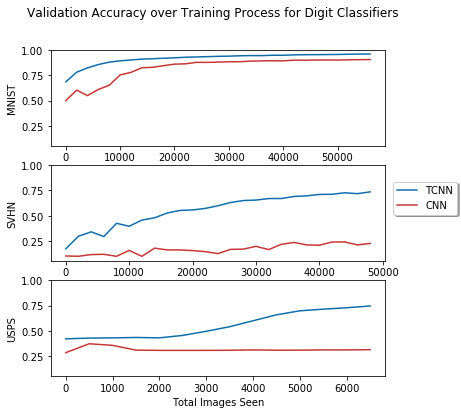

In [34]:
## Version for GC
gc_color_dict1 = {'KF + KOL': '#0e6eab', 'NOL + NOL': '#c73634'}
name_dict = {'KF + KOL': 'TCNN', 'NOL + NOL': 'CNN'}

fig, axarr = plt.subplots(3, sharex=False,sharey=True)
# fig.suptitle('Accuracy on Several Digit Datasets')
dataset='MNIST'
configuration=results[dataset]
for name, item in configuration.items():
    if name in list(gc_color_dict1.keys()):
        axarr[0].plot([i*item['config']['batchesPerTest']*item['config']['batchSize'] for i in range(len(item['accuracies']))],
                 item['accuracies'], label=name_dict[name], color=gc_color_dict1[name])
dataset='SVHN'
configuration=results[dataset]
for name, item in configuration.items():
    if name in list(gc_color_dict1.keys()):
        axarr[1].plot([i*item['config']['batchesPerTest']*item['config']['batchSize'] for i in range(len(item['accuracies']))],
                 item['accuracies'], color=gc_color_dict1[name])
dataset='USPS'
configuration=results[dataset]
for name, item in configuration.items():
    if name in list(gc_color_dict1.keys()):
        axarr[2].plot([i*item['config']['batchesPerTest']*item['config']['batchSize'] for i in range(len(item['accuracies']))],
                 item['accuracies'], color=gc_color_dict1[name])
    
axarr[0].set(ylabel='MNIST')
fig.suptitle('Validation Accuracy over Training Process for Digit Classifiers')
axarr[1].set(ylabel='SVHN')
axarr[2].set(ylabel='USPS')
fig.legend(loc='center right', shadow=True, bbox_to_anchor=(1.07,.5))
fig.set_figheight(6)
fig.set_figwidth(6)
axarr[2].set_xlabel('Total Images Seen')
fig.show()

# fig.savefig('/home/ephy/Projects/tda_convolution/fig/digitClassAccuracies_best_newPoly.png', dpi=300, bbox_inches='tight')

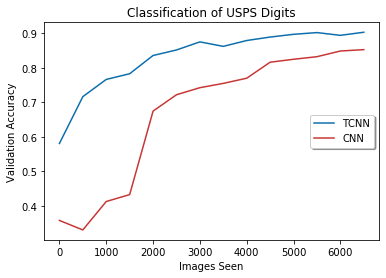

In [79]:
## Version for GC
gc_color_dict1 = {'KF + KOL': '#0e6eab', 'NOL + NOL': '#c73634'}
name_dict = {'KF + KOL': 'TCNN', 'NOL + NOL': 'CNN'}

dataset='USPS'
configuration=results[dataset]
for name, item in configuration.items():
    if name in list(gc_color_dict1.keys()):
        plt.plot([i*item['config']['batchesPerTest']*item['config']['batchSize'] for i in range(len(item['accuracies']))],
                 item['accuracies'], color=gc_color_dict1[name], label=name_dict[name])

plt.title('Classification of USPS Digits')
plt.ylabel('Validation Accuracy')
plt.xlabel('Images Seen')
plt.legend(loc='center right', shadow=True)
# plt.show()

# plt.savefig('/home/ephy/Projects/tda_convolution/fig/uspsAccuracies_forGC.png', dpi=300, bbox_inches='tight')